In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
############
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from numpy import interp

C:\Users\MVI_lab_2\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df=pd.read_csv('C:/Users/MVI_lab_2/Desktop/sezier_detection_LSTM/merge_preictal_ictal.csv')
arr = df.to_numpy()
x = arr[:, :-1]  
y = arr[:, -1]   

# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 12)
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify = y, test_size = 0.2,  random_state=42)

In [3]:
unique_values_x = set(x.flatten())
unique_values_y = set(y)

In [4]:
print(unique_values_x)
print(unique_values_y)

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23}
{0, 1}


In [5]:
from keras.layers import Conv1D, BatchNormalization, Concatenate, ReLU, MaxPooling1D, Flatten, Dense, Embedding
from keras import Input, Model
from keras.optimizers import Adam

def get_block(inp, filter):
  cnn = Conv1D(kernel_size=10, filters=filter, padding='same')(inp)
  bn = BatchNormalization()(cnn)
  relu = ReLU()(bn)
  return relu

def get_model():
  ip = Input(shape=(460,))
  embedding = Embedding(input_dim=24, output_dim=16)(ip) 

  branch1_1 = MaxPooling1D(pool_size=2)(get_block(embedding, 16))

  branch2_ip = MaxPooling1D(pool_size=2)(embedding)
  branch2_1 = get_block(branch2_ip, 32)
  branch2_2 = get_block(MaxPooling1D(pool_size=2)(branch2_1), 32)
  branch2_3 = get_block(MaxPooling1D(pool_size=2)(branch2_2), 32)
  branch2_4 = get_block(MaxPooling1D(pool_size=2)(branch2_3), 32)

  branch3_ip = MaxPooling1D(pool_size=2)(branch2_ip)
  branch3_1 = get_block(branch3_ip, 64)
  branch3_2 = get_block(MaxPooling1D(pool_size=2)(branch3_1), 64)
  branch3_3 = get_block(MaxPooling1D(pool_size=2)(branch3_2), 64)

  branch4_ip = MaxPooling1D(pool_size=2)(branch3_ip)
  branch4_1 = get_block(branch4_ip, 128)
  branch4_2 = get_block(MaxPooling1D(pool_size=2)(branch4_1), 128)

  branch5_ip = MaxPooling1D(pool_size=2)(branch4_ip)
  branch5_1 = get_block(branch5_ip, 256)

  branch1_2 = MaxPooling1D(pool_size=2)(get_block(Concatenate()([branch1_1, branch2_1]), 16))
  branch1_3 = MaxPooling1D(pool_size=2)(get_block(Concatenate()([branch1_2, branch2_2, branch3_1]), 16))
  branch1_4 = MaxPooling1D(pool_size=2)(get_block(Concatenate()([branch1_3, branch2_3, branch3_2, branch4_1]), 16))
  branch1_5 = get_block(Concatenate()([branch1_4, branch2_4, branch3_3, branch4_2, branch5_1]), 256)

  flatten = Flatten()(branch1_5)
  dense = Dense(32, activation='relu')(flatten)
  op = Dense(1, activation='sigmoid')(dense) # Binary classification, so 1 output neuron with sigmoid activation
  model = Model(inputs=ip, outputs=op)
  return model

model = get_model()
model.summary()





Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 460)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 460, 16)              384       ['input_1[0][0]']             
                                                                                                  
 conv1d (Conv1D)             (None, 460, 16)              2576      ['embedding[0][0]']           
                                                                                                  
 max_pooling1d_1 (MaxPoolin  (None, 230, 16)              0         ['embedding[0][0]']           
 g1D)                                                                                      

 max_pooling1d_8 (MaxPoolin  (None, 57, 16)               0         ['max_pooling1d_5[0][0]']     
 g1D)                                                                                             
                                                                                                  
 batch_normalization_12 (Ba  (None, 115, 16)              64        ['conv1d_12[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 conv1d_3 (Conv1D)           (None, 57, 32)               10272     ['max_pooling1d_3[0][0]']     
                                                                                                  
 conv1d_6 (Conv1D)           (None, 57, 64)               41024     ['max_pooling1d_6[0][0]']     
                                                                                                  
 conv1d_8 

                                                                                                  
 re_lu_4 (ReLU)              (None, 28, 32)               0         ['batch_normalization_4[0][0]'
                                                                    ]                             
                                                                                                  
 re_lu_7 (ReLU)              (None, 28, 64)               0         ['batch_normalization_7[0][0]'
                                                                    ]                             
                                                                                                  
 re_lu_9 (ReLU)              (None, 28, 128)              0         ['batch_normalization_9[0][0]'
                                                                    ]                             
                                                                                                  
 re_lu_10 

In [6]:
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [7]:
import os
from keras.callbacks import ModelCheckpoint, CSVLogger
from keras.models import Sequential
# Example model definition and other setup code might go here

# Define the directory path for model weights and entire model
model_weights_directory = "C:/Users/MVI_lab_2/Desktop/sezier_detection_LSTM/final_model/ModelWeights/"
model_directory = "C:/Users/MVI_lab_2/Desktop/sezier_detection_LSTM/final_model/Model/"

# Ensure the directories exist
os.makedirs(model_weights_directory, exist_ok=True)
os.makedirs(model_directory, exist_ok=True)

# Filenames for weights and the entire model
# Filenames for weights and the entire model
model_weights_filename = "1dcnn_final_model_binaryclass_best_weights.h5"
model_filename = "1dcnn_final_binaryclass_best.h5"  # Update file extension to .keras

# Filepaths
model_weights_filepath = os.path.join(model_weights_directory, model_weights_filename)
model_filepath = os.path.join(model_directory, model_filename)

# Callback to save the best model weights
checkpoint_weights = ModelCheckpoint(
    model_weights_filepath,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='max'
)

# Callback to save the best entire model
checkpoint_model = ModelCheckpoint(
    model_filepath,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='max'
)

# Directory path for saving training results
results_directory = "C:/Users/MVI_lab_2/Desktop/sezier_detection_LSTM/final_model/Result/"
os.makedirs(results_directory, exist_ok=True)

# Filename for saving training results
results_filename = "1dcnn_final_model_output.csv"
results_filepath = os.path.join(results_directory, results_filename)

# CSVLogger callback
csv_logger = CSVLogger(results_filepath, separator=',', append=True)

# List of callbacks
callbacks_list = [checkpoint_weights, checkpoint_model, csv_logger]

# Model training (assuming `model` is your model instance)
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=25,
    verbose=1,
    callbacks=callbacks_list
)

# Since we are using ModelCheckpoint to save the best model, there's no need to save the model explicitly at the end of training


Epoch 1/25


52429/52429 [==============================] - ETA: 0s - loss: 0.2886 - accuracy: 0.8780
Epoch 1: val_accuracy improved from -inf to 0.91124, saving model to C:/Users/MVI_lab_2/Desktop/sezier_detection_LSTM/final_model/ModelWeights\1dcnn_final_model_binaryclass_best_weights.h5

Epoch 1: val_accuracy improved from -inf to 0.91124, saving model to C:/Users/MVI_lab_2/Desktop/sezier_detection_LSTM/final_model/Model\1dcnn_final_binaryclass_best.h5
52429/52429 [==============================] - 2134s 41ms/step - loss: 0.2886 - accuracy: 0.8780 - val_loss: 0.2198 - val_accuracy: 0.9112
Epoch 2/25


C:\Users\MVI_lab_2\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


52429/52429 [==============================] - ETA: 0s - loss: 0.1894 - accuracy: 0.9243
Epoch 2: val_accuracy improved from 0.91124 to 0.93288, saving model to C:/Users/MVI_lab_2/Desktop/sezier_detection_LSTM/final_model/ModelWeights\1dcnn_final_model_binaryclass_best_weights.h5

Epoch 2: val_accuracy improved from 0.91124 to 0.93288, saving model to C:/Users/MVI_lab_2/Desktop/sezier_detection_LSTM/final_model/Model\1dcnn_final_binaryclass_best.h5
52429/52429 [==============================] - 2084s 40ms/step - loss: 0.1894 - accuracy: 0.9243 - val_loss: 0.1702 - val_accuracy: 0.9329
Epoch 3/25
52429/52429 [==============================] - ETA: 0s - loss: 0.1369 - accuracy: 0.9464
Epoch 3: val_accuracy improved from 0.93288 to 0.94561, saving model to C:/Users/MVI_lab_2/Desktop/sezier_detection_LSTM/final_model/ModelWeights\1dcnn_final_model_binaryclass_best_weights.h5

Epoch 3: val_accuracy improved from 0.93288 to 0.94561, saving model to C:/Users/MVI_lab_2/Desktop/sezier_detection


Epoch 16: val_accuracy improved from 0.96967 to 0.97045, saving model to C:/Users/MVI_lab_2/Desktop/sezier_detection_LSTM/final_model/Model\1dcnn_final_binaryclass_best.h5
52429/52429 [==============================] - 2141s 41ms/step - loss: 0.0190 - accuracy: 0.9932 - val_loss: 0.0996 - val_accuracy: 0.9705
Epoch 17/25
52428/52429 [============================>.] - ETA: 0s - loss: 0.0176 - accuracy: 0.9937
Epoch 17: val_accuracy improved from 0.97045 to 0.97133, saving model to C:/Users/MVI_lab_2/Desktop/sezier_detection_LSTM/final_model/ModelWeights\1dcnn_final_model_binaryclass_best_weights.h5

Epoch 17: val_accuracy improved from 0.97045 to 0.97133, saving model to C:/Users/MVI_lab_2/Desktop/sezier_detection_LSTM/final_model/Model\1dcnn_final_binaryclass_best.h5
52429/52429 [==============================] - 2117s 40ms/step - loss: 0.0176 - accuracy: 0.9937 - val_loss: 0.1013 - val_accuracy: 0.9713
Epoch 18/25
52429/52429 [==============================] - ETA: 0s - loss: 0.0167 

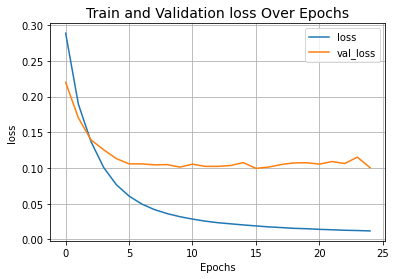

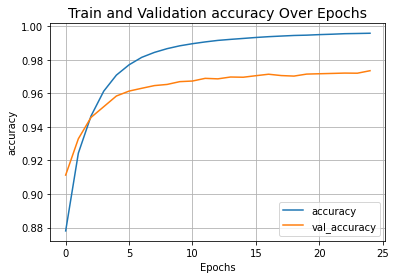

In [8]:
import os

def plot_history(history, item, save_as=None, file_path=None):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    if save_as:
        if file_path is None:
            file_path = os.path.join(os.path.expanduser('~'), 'Desktop', 'pic')
        plt.savefig(os.path.join(file_path, save_as + ".png"))
    plt.show()

# Plot and save the loss history
plot_history(history, "loss", save_as="1dcnn_final_loss", file_path="C:/Users/MVI_lab_2/Desktop/sezier_detection_LSTM/final_model/images/")

# Plot and save the accuracy history
plot_history(history, "accuracy", save_as="1dcnn_final_accuracy", file_path="C:/Users/MVI_lab_2/Desktop/sezier_detection_LSTM/final_model/images/")


13108/13108 [==============================] - 125s 9ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97    209715
           1       0.98      0.97      0.97    209714

    accuracy                           0.97    419429
   macro avg       0.97      0.97      0.97    419429
weighted avg       0.97      0.97      0.97    419429

Confusion Matrix:
[[204685   5030]
 [  6118 203596]]


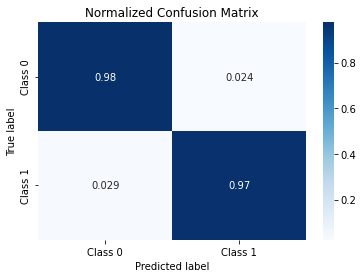

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # Added for heatmap visualization

# Assuming you have the model already trained and `x_test` and `y_test` data available
# Assuming `model` is the trained model

# Generate predictions
y_pred_prob = model.predict(x_test).ravel()  # Use `.ravel()` if model.predict returns a 2D array for a single output model
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to class labels based on a 0.5 threshold

# Generate classification report and save to file
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

# Save classification report to text file
with open('C:/Users/MVI_lab_2/Desktop/sezier_detection_LSTM/final_model/images/classification_report.txt', 'w') as f:
    f.write("Classification Report:\n")
    f.write(report)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot normalized confusion matrix using Seaborn
plt.figure()
cm_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')

# Save the confusion matrix plot
plt.savefig('C:/Users/MVI_lab_2/Desktop/sezier_detection_LSTM/final_model/images/confusion_matrix.png')

plt.show()


13108/13108 [==============================] - 156s 12ms/step


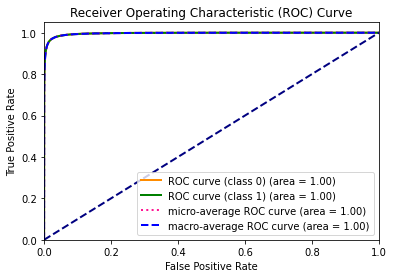

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_ROC_curves(y_true, y_pred_prob, save_path=None):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Compute ROC curve and ROC area for each class
    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(y_true, y_pred_prob)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true, y_pred_prob)
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(2)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(2):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= 2
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.figure()
    lw = 2
    plt.plot(fpr[0], tpr[0], color='darkorange', lw=lw, label='ROC curve (class 0) (area = %0.2f)' % roc_auc[0])
    plt.plot(fpr[1], tpr[1], color='green', lw=lw, label='ROC curve (class 1) (area = %0.2f)' % roc_auc[1])
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', lw=lw, linestyle=':', label='micro-average ROC curve (area = %0.2f)' % roc_auc["micro"])
    plt.plot(fpr["macro"], tpr["macro"], color='blue', lw=lw, linestyle='--', label='macro-average ROC curve (area = %0.2f)' % roc_auc["macro"])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    
    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path)
    
    plt.show()

# Assuming you have the model already trained and `x_test` and `y_test` data available
# Assuming `model` is the trained model

# Generate predictions
y_pred_prob = model.predict(x_test).ravel()  # get probabilities for the positive class

# Plot ROC curves and save the plot
plot_ROC_curves(y_test, y_pred_prob, save_path='C:/Users/MVI_lab_2/Desktop/sezier_detection_LSTM/final_model/images/ROC_curve.png')


In [11]:
import tensorflow as tf

# Load the saved model
model = tf.keras.models.load_model('C:/Users/MVI_lab_2/Desktop/sezier_detection_LSTM/final_model/Model/1dcnn_final_binaryclass_best.h5')

# Load test data
#test_data = ...  # Load your test data here
#test_y_onehot = ...  # Load one-hot encoded test labels here

# Evaluate the model
evaluation = model.evaluate(x_test, y_test)

# Print evaluation metrics
print("Evaluation Loss:", evaluation[0])
print("Evaluation Accuracy:", evaluation[1])


13108/13108 [==============================] - 147s 11ms/step - loss: 0.1005 - accuracy: 0.9734
Evaluation Loss: 0.10046490281820297
Evaluation Accuracy: 0.973421037197113


In [12]:
from keras.models import load_model

# Load the model
model = load_model('C:/Users/MVI_lab_2/Desktop/sezier_detection_LSTM/final_model/Model/1dcnn_final_binaryclass_best.h5')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 460)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 460, 16)              384       ['input_1[0][0]']             
                                                                                                  
 conv1d (Conv1D)             (None, 460, 16)              2576      ['embedding[0][0]']           
                                                                                                  
 max_pooling1d_1 (MaxPoolin  (None, 230, 16)              0         ['embedding[0][0]']           
 g1D)                                                                                         

                                                                                                  
 conv1d_6 (Conv1D)           (None, 57, 64)               41024     ['max_pooling1d_6[0][0]']     
                                                                                                  
 conv1d_8 (Conv1D)           (None, 57, 128)              20608     ['max_pooling1d_8[0][0]']     
                                                                                                  
 re_lu_12 (ReLU)             (None, 115, 16)              0         ['batch_normalization_12[0][0]
                                                                    ']                            
                                                                                                  
 batch_normalization_3 (Bat  (None, 57, 32)               128       ['conv1d_3[0][0]']            
 chNormalization)                                                                                 
          

 re_lu_9 (ReLU)              (None, 28, 128)              0         ['batch_normalization_9[0][0]'
                                                                    ]                             
                                                                                                  
 re_lu_10 (ReLU)             (None, 28, 256)              0         ['batch_normalization_10[0][0]
                                                                    ']                            
                                                                                                  
 concatenate_3 (Concatenate  (None, 28, 496)              0         ['max_pooling1d_13[0][0]',    
 )                                                                   're_lu_4[0][0]',             
                                                                     're_lu_7[0][0]',             
                                                                     're_lu_9[0][0]',             
          

In [13]:
# Print each layer's name
for layer in model.layers:
    print(layer.name)

input_1
embedding
conv1d
max_pooling1d_1
batch_normalization
conv1d_1
re_lu
batch_normalization_1
max_pooling1d
re_lu_1
concatenate
conv1d_11
max_pooling1d_2
max_pooling1d_5
batch_normalization_11
conv1d_2
conv1d_5
re_lu_11
batch_normalization_2
batch_normalization_5
max_pooling1d_11
re_lu_2
re_lu_5
concatenate_1
conv1d_12
max_pooling1d_3
max_pooling1d_6
max_pooling1d_8
batch_normalization_12
conv1d_3
conv1d_6
conv1d_8
re_lu_12
batch_normalization_3
batch_normalization_6
batch_normalization_8
max_pooling1d_12
re_lu_3
re_lu_6
re_lu_8
concatenate_2
conv1d_13
max_pooling1d_4
max_pooling1d_7
max_pooling1d_9
max_pooling1d_10
batch_normalization_13
conv1d_4
conv1d_7
conv1d_9
conv1d_10
re_lu_13
batch_normalization_4
batch_normalization_7
batch_normalization_9
batch_normalization_10
max_pooling1d_13
re_lu_4
re_lu_7
re_lu_9
re_lu_10
concatenate_3
conv1d_14
batch_normalization_14
re_lu_14
flatten
dense
dense_1


In [14]:
from keras.models import Model

# Get the output of the conv1d_14 layer
conv1d_14_output = model.get_layer('conv1d_14').output

# Add a flatten layer to reshape the output
flatten = Flatten()(conv1d_14_output)

# Add a dense layer with 512 neurons
dense_layer = Dense(264, activation='relu')(flatten)

# Define the new model with the layers added
cnn_base = Model(inputs=model.input, outputs=dense_layer)

# Freeze layers up to conv1d_14
for layer in cnn_base.layers[:cnn_base.layers.index(model.get_layer('conv1d_14'))]:
    layer.trainable = False

cnn_base.summary()

# Extract features from the modified model
X_train_features = cnn_base.predict(x_train)
X_test_features = cnn_base.predict(x_test)

print(X_train_features.shape)
print(X_test_features.shape)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 460)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 460, 16)              384       ['input_1[0][0]']             
                                                                                                  
 conv1d (Conv1D)             (None, 460, 16)              2576      ['embedding[0][0]']           
                                                                                                  
 max_pooling1d_1 (MaxPoolin  (None, 230, 16)              0         ['embedding[0][0]']           
 g1D)                                                                                       

                                                                                                  
 conv1d_6 (Conv1D)           (None, 57, 64)               41024     ['max_pooling1d_6[0][0]']     
                                                                                                  
 conv1d_8 (Conv1D)           (None, 57, 128)              20608     ['max_pooling1d_8[0][0]']     
                                                                                                  
 re_lu_12 (ReLU)             (None, 115, 16)              0         ['batch_normalization_12[0][0]
                                                                    ']                            
                                                                                                  
 batch_normalization_3 (Bat  (None, 57, 32)               128       ['conv1d_3[0][0]']            
 chNormalization)                                                                                 
          

 re_lu_9 (ReLU)              (None, 28, 128)              0         ['batch_normalization_9[0][0]'
                                                                    ]                             
                                                                                                  
 re_lu_10 (ReLU)             (None, 28, 256)              0         ['batch_normalization_10[0][0]
                                                                    ']                            
                                                                                                  
 concatenate_3 (Concatenate  (None, 28, 496)              0         ['max_pooling1d_13[0][0]',    
 )                                                                   're_lu_4[0][0]',             
                                                                     're_lu_7[0][0]',             
                                                                     're_lu_9[0][0]',             
          

In [15]:
import numpy as np

# Flatten the features
X_train_flattened = X_train_features.reshape(X_train_features.shape[0], -1)
X_test_flattened = X_test_features.reshape(X_test_features.shape[0], -1)

print(X_train_flattened.shape)
print(X_test_flattened.shape)

print(y_train.shape)
print(y_test.shape)

(1677713, 264)
(419429, 264)
(1677713,)
(419429,)


In [16]:
import numpy as np

# Flatten the features
X_train_flattened = X_train_features.reshape(X_train_features.shape[0], -1)
X_test_flattened = X_test_features.reshape(X_test_features.shape[0], -1)

# Save the flattened features
np.save('C:/Users/MVI_lab_2/Desktop/sezier_detection_LSTM/final_model/features/cnn_X_train_features.npy', X_train_flattened)
np.save('C:/Users/MVI_lab_2/Desktop/sezier_detection_LSTM/final_model/features/cnn_X_test_features.npy', X_test_flattened)

# Save the labels
np.save('C:/Users/MVI_lab_2/Desktop/sezier_detection_LSTM/final_model/features/cnn_y_train.npy', y_train)
np.save('C:/Users/MVI_lab_2/Desktop/sezier_detection_LSTM/final_model/features/cnn_y_test.npy', y_test)

print("Features saved successfully.")


Features saved successfully.


## reading the features since error occured

In [17]:
# import numpy as np

# # Load flattened features
# X_train_flattened = np.load('C:/Users/MVI_lab_2/Desktop/sezier_detection_LSTM/final_model/features/cnn_X_train_features.npy')
# X_test_flattened = np.load('C:/Users/MVI_lab_2/Desktop/sezier_detection_LSTM/final_model/features/cnn_X_test_features.npy')

# # Load labels
# y_train = np.load('C:/Users/MVI_lab_2/Desktop/sezier_detection_LSTM/final_model/features/cnn_y_train.npy')
# y_test = np.load('C:/Users/MVI_lab_2/Desktop/sezier_detection_LSTM/final_model/features/cnn_y_test.npy')

# print("Features and labels loaded successfully.")


## Prediction through Decision Tree Classifier

In [18]:
# Train a Decision Tree classifier
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train_flattened, y_train)

decision_tree_predictions = decision_tree.predict(X_test_flattened)

# Calculate accuracy
decision_tree_accuracy = accuracy_score(y_test, decision_tree_predictions)
print("Decision Tree Accuracy:", decision_tree_accuracy)

Decision Tree Accuracy: 0.7785703897441522


In [19]:
from sklearn import metrics

# Generate classification report with zero_division parameter set to "warn"
report = metrics.classification_report(y_test, decision_tree_predictions)

# Print the report
print(report)

# Save the classification report to a file
with open("C:/Users/MVI_lab_2/Desktop/sezier_detection_LSTM/final_model/images/cnn_decision_tree_classification_report.txt", "w") as file:
    file.write(report)


              precision    recall  f1-score   support

           0       0.78      0.78      0.78    209715
           1       0.78      0.78      0.78    209714

    accuracy                           0.78    419429
   macro avg       0.78      0.78      0.78    419429
weighted avg       0.78      0.78      0.78    419429



Confusion Matrix: 
 [[163517  46198]
 [ 46676 163038]]
Normalized Confusion Matrix:
 [[0.77971056 0.22028944]
 [0.22256979 0.77743021]]


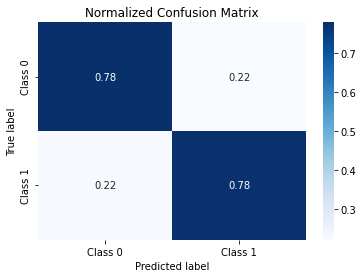

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, decision_tree_predictions)
print("Confusion Matrix: \n", cnf_matrix)

# Normalize confusion matrix
cm_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
print("Normalized Confusion Matrix:\n", cm_normalized)

classes = ['Class 0', 'Class 1']

# Plot normalized confusion matrix using Seaborn
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')

# Save the confusion matrix plot as an image file
plt.savefig('C:/Users/MVI_lab_2/Desktop/sezier_detection_LSTM/final_model/images/cnn_decision_tree_confusion_matrix.png')

plt.show()


C:\Users\MVI_lab_2\AppData\Local\Temp\ipykernel_6372\507812794.py:26: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


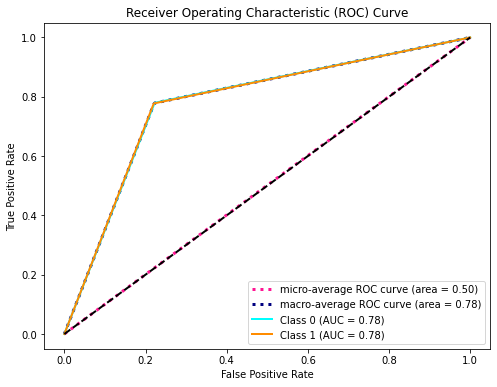

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from scipy import interp

def plot_AUC_ROC(y_true, y_pred, n_classes):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred == i)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve((y_true.ravel() == y_pred.ravel()), (y_pred.ravel() == 1))
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
        
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot ROC curves
    plt.figure(figsize=(8, 6))
    plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]), color='deeppink', linestyle='dotted', linewidth=3)
    plt.plot(fpr["macro"], tpr["macro"], label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]), color='navy', linestyle=':', linewidth=3)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, linewidth=2, label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    
    # Save the AUC ROC curve plot as an image file
    plt.savefig('C:/Users/MVI_lab_2/Desktop/sezier_detection_LSTM/final_model/images/cnn_decision_tree_auc_roc_curve.png')
    
    plt.show()

# Example usage:
n_classes = 2  # Assuming binary classification
plot_AUC_ROC(y_test, decision_tree_predictions, n_classes)

## Prediction through random forest classifier

In [22]:
# Train Random Forest classifier
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=200)
rf_classifier.fit(X_train_flattened, y_train)

# Evaluate Random Forest classifier
rf_predictions = rf_classifier.predict(X_test_flattened)

# Calculate accuracy
rf_accuracy = accuracy_score(y_test, rf_predictions)
print("Random Forest Accuracy:", rf_accuracy)

Random Forest Accuracy: 0.8810335003063688


In [23]:
from sklearn import metrics
report = metrics.classification_report(y_test, rf_predictions, zero_division='warn')
print(report)
with open('C:/Users/MVI_lab_2/Desktop/sezier_detection_LSTM/final_model/images/cnn_random_forestclassification_report.txt', 'w') as file:
    file.write(report)


              precision    recall  f1-score   support

           0       0.88      0.88      0.88    209715
           1       0.88      0.89      0.88    209714

    accuracy                           0.88    419429
   macro avg       0.88      0.88      0.88    419429
weighted avg       0.88      0.88      0.88    419429



Confusion Matrix: 
 [[183705  26010]
 [ 23888 185826]]
Normalized Confusion Matrix:
 [[0.87597454 0.12402546]
 [0.11390751 0.88609249]]


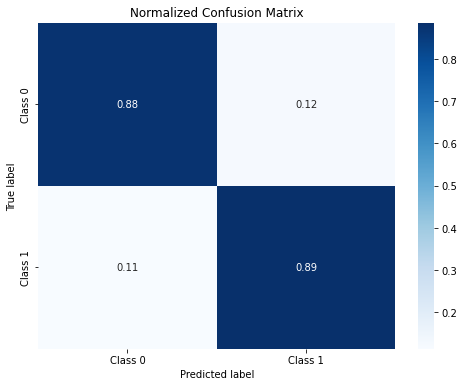

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

# Assume y_test and rf_predictions are already defined, as well as 'classes'
cnf_matrix = metrics.confusion_matrix(y_test, rf_predictions)
print("Confusion Matrix: \n", cnf_matrix)

# Normalize confusion matrix
cm_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
print("Normalized Confusion Matrix:\n", cm_normalized)

# Plot normalized confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Save the figure
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.savefig('C:/Users/MVI_lab_2/Desktop/sezier_detection_LSTM/final_model/images/cnn_random_forestnormalized_confusion_matrix.png')  # Save the figure to a file
plt.close()  # Close the figure explicitly after saving it


C:\Users\MVI_lab_2\AppData\Local\Temp\ipykernel_6372\1591112157.py:26: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


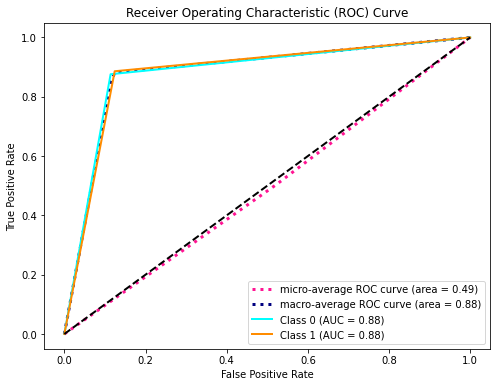

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from scipy import interp

def plot_AUC_ROC(y_true, y_pred, n_classes):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred == i)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve((y_true.ravel() == y_pred.ravel()), (y_pred.ravel() == 1))
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
        
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot ROC curves
    plt.figure(figsize=(8, 6))
    plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]), color='deeppink', linestyle='dotted', linewidth=3)
    plt.plot(fpr["macro"], tpr["macro"], label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]), color='navy', linestyle=':', linewidth=3)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, linewidth=2, label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    
    # Save the AUC ROC curve plot as an image file
    plt.savefig('C:/Users/MVI_lab_2/Desktop/sezier_detection_LSTM/final_model/images/cnn_random_forest_auc_roc_curve.png')
    
    plt.show()

# Example usage:
n_classes = 2  # Assuming binary classification
plot_AUC_ROC(y_test, rf_predictions, n_classes)

## Prediction through Support Vector Machine Classifier

In [26]:
# from sklearn.svm import SVC

# svm_classifier = SVC(kernel='linear')
# svm_classifier.fit(X_train_flattened, y_train)

# # Predictions on test set
# svm_predictions = svm_classifier.predict(X_test_flattened)

# # Calculate accuracy
# svm_accuracy = accuracy_score(y_test, svm_predictions)
# print("SVM Accuracy:", svm_accuracy)

In [27]:
# from sklearn import metrics
# report = metrics.classification_report(y_test, svm_predictions)
# print(report)
# with open('C:/Users/MVI_lab_2/Desktop/sezier_detection_LSTM/final_model/images/cnn_svm_classification_report.txt', 'w') as file:
#     file.write(report)


In [28]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# from sklearn import metrics

# cnf_matrix = metrics.confusion_matrix(y_test, svm_predictions)
# print("Confusion Matrix: \n", cnf_matrix)

# # Normalize confusion matrix
# cm_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
# print("Normalized Confusion Matrix:\n", cm_normalized)

# classes = ['Class 0', 'Class 1']

# # Plot normalized confusion matrix using Seaborn
# sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=classes, yticklabels=classes)
# plt.title('Normalized Confusion Matrix')
# plt.xlabel('Predicted label')
# plt.ylabel('True label')

# # Save the confusion matrix plot as an image file
# plt.savefig('C:/Users/MVI_lab_2/Desktop/sezier_detection_LSTM/final_model/images/cnn_svm_confusion_matrix.png')

# plt.show()

In [29]:
# import numpy as np
# import matplotlib.pyplot as plt
# from itertools import cycle
# from sklearn.metrics import roc_curve, auc
# from scipy import interp

# def plot_AUC_ROC(y_true, y_pred, n_classes):
#     # Compute ROC curve and ROC area for each class
#     fpr = dict()
#     tpr = dict()
#     roc_auc = dict()

#     for i in range(n_classes):
#         fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred == i)
#         roc_auc[i] = auc(fpr[i], tpr[i])

#     # Compute micro-average ROC curve and ROC area
#     fpr["micro"], tpr["micro"], _ = roc_curve((y_true.ravel() == y_pred.ravel()), (y_pred.ravel() == 1))
#     roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

#     # Compute macro-average ROC curve and ROC area
#     all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
#     mean_tpr = np.zeros_like(all_fpr)
    
#     for i in range(n_classes):
#         mean_tpr += interp(all_fpr, fpr[i], tpr[i])
        
#     mean_tpr /= n_classes
#     fpr["macro"] = all_fpr
#     tpr["macro"] = mean_tpr
#     roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

#     # Plot ROC curves
#     plt.figure(figsize=(8, 6))
#     plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]), color='deeppink', linestyle='dotted', linewidth=3)
#     plt.plot(fpr["macro"], tpr["macro"], label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]), color='navy', linestyle=':', linewidth=3)

#     colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
#     for i, color in zip(range(n_classes), colors):
#         plt.plot(fpr[i], tpr[i], color=color, linewidth=2, label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

#     plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Receiver Operating Characteristic (ROC) Curve')
#     plt.legend(loc="lower right")
    
#     # Save the AUC ROC curve plot as an image file
#     plt.savefig('C:/Users/MVI_lab_2/Desktop/sezier_detection_LSTM/final_model/images/cnn_svm_auc_roc_curve.png')
    
#     plt.show()

# # Example usage:
# n_classes = 2  # Assuming binary classification
# plot_AUC_ROC(y_test, svm_predictions, n_classes)

## Prediction Through Naive Bayes Classifier

In [30]:
from sklearn.naive_bayes import GaussianNB

# Define and train the Naive Bayes classifier
naive_bayes = GaussianNB()
naive_bayes.fit(X_train_flattened, y_train)

# Make predictions on the test set
nb_predictions = naive_bayes.predict(X_test_flattened)

# Evaluate the performance of the Naive Bayes classifier
nb_accuracy = accuracy_score(y_test, nb_predictions)
print("Naive Bayes Accuracy:", nb_accuracy)

Naive Bayes Accuracy: 0.8019187991292924


In [31]:
from sklearn import metrics
report = metrics.classification_report(y_test, nb_predictions)
print(report)
with open('C:/Users/MVI_lab_2/Desktop/sezier_detection_LSTM/final_model/images/cnn_naive_bayes_classification_report.txt', 'w') as file:
    file.write(report)


              precision    recall  f1-score   support

           0       0.79      0.81      0.80    209715
           1       0.81      0.79      0.80    209714

    accuracy                           0.80    419429
   macro avg       0.80      0.80      0.80    419429
weighted avg       0.80      0.80      0.80    419429



Confusion Matrix: 
 [[170912  38803]
 [ 44278 165436]]
Normalized Confusion Matrix:
 [[0.8149727  0.1850273 ]
 [0.21113517 0.78886483]]


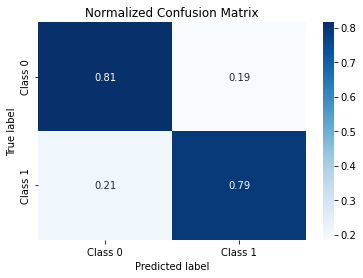

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, nb_predictions)
print("Confusion Matrix: \n", cnf_matrix)

# Normalize confusion matrix
cm_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
print("Normalized Confusion Matrix:\n", cm_normalized)

classes = ['Class 0', 'Class 1']

# Plot normalized confusion matrix using Seaborn
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')

# Save the confusion matrix plot as an image file
plt.savefig('C:/Users/MVI_lab_2/Desktop/sezier_detection_LSTM/final_model/images/cnn_naive_bayes_confusion_matrix.png')

plt.show()

In [33]:
# print(y_test_flattened)
# print(y_test)

print(nb_predictions)

nb_matrix = np.zeros((nb_predictions.size, 2))

for i in range(0,nb_predictions.size):
  if(nb_predictions[i] == 1):
    nb_matrix[i][1] = 1
  else:
    nb_matrix[i][0] = 1

print(nb_matrix)

[0 1 1 ... 0 0 0]
[[1. 0.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


C:\Users\MVI_lab_2\AppData\Local\Temp\ipykernel_6372\1393168647.py:26: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


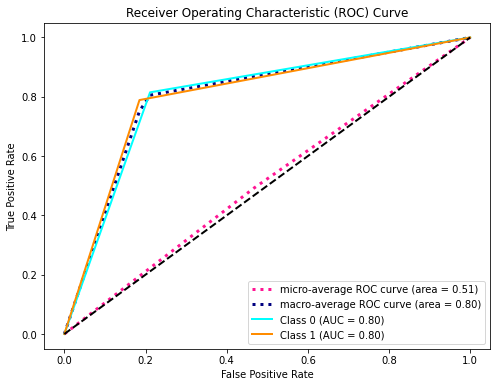

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from scipy import interp

def plot_AUC_ROC(y_true, y_pred, n_classes):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred == i)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve((y_true.ravel() == y_pred.ravel()), (y_pred.ravel() == 1))
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
        
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot ROC curves
    plt.figure(figsize=(8, 6))
    plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]), color='deeppink', linestyle='dotted', linewidth=3)
    plt.plot(fpr["macro"], tpr["macro"], label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]), color='navy', linestyle=':', linewidth=3)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, linewidth=2, label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    
    # Save the AUC ROC curve plot as an image file
    plt.savefig('C:/Users/MVI_lab_2/Desktop/sezier_detection_LSTM/final_model/images/cnn_naive_bayes_auc_roc_curve.png')
    
    plt.show()

# Example usage:
n_classes = 2  # Assuming binary classification
plot_AUC_ROC(y_test, nb_predictions, n_classes)

## Prediction through Logistic Regression Classifier

In [35]:
# Create an instance of the LogisticRegression class

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Scale the input features
scaler = StandardScaler()
X_train_features_scaled = scaler.fit_transform(X_train_flattened)
X_test_features_scaled = scaler.transform(X_test_flattened)

# Create and train the logistic regression model with increased max_iter
logistic_regression = LogisticRegression(max_iter=1000)
logistic_regression.fit(X_train_features_scaled, y_train)

# Make predictions and evaluate the model
logistic_regression_predictions = logistic_regression.predict(X_test_features_scaled)

logistic_regression_accuracy = accuracy_score(y_test, logistic_regression_predictions)
print("Logistic Regression Accuracy:", logistic_regression_accuracy)


Logistic Regression Accuracy: 0.8389238703093969


In [36]:
from sklearn import metrics
report = metrics.classification_report(y_test, logistic_regression_predictions)
print(report)
with open('C:/Users/MVI_lab_2/Desktop/sezier_detection_LSTM/final_model/images/cnn_logistic_regression_classification_report.txt', 'w') as file:
    file.write(report)


              precision    recall  f1-score   support

           0       0.84      0.84      0.84    209715
           1       0.84      0.83      0.84    209714

    accuracy                           0.84    419429
   macro avg       0.84      0.84      0.84    419429
weighted avg       0.84      0.84      0.84    419429



Confusion Matrix: 
 [[177136  32579]
 [ 34981 174733]]
Normalized Confusion Matrix:
 [[0.84465107 0.15534893]
 [0.16680336 0.83319664]]


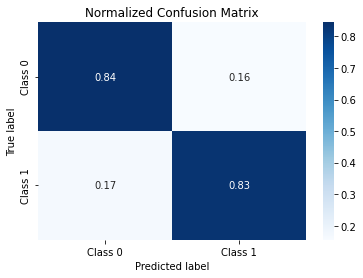

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, logistic_regression_predictions)
print("Confusion Matrix: \n", cnf_matrix)

# Normalize confusion matrix
cm_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
print("Normalized Confusion Matrix:\n", cm_normalized)

classes = ['Class 0', 'Class 1']

# Plot normalized confusion matrix using Seaborn
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')

# Save the confusion matrix plot as an image file
plt.savefig('C:/Users/MVI_lab_2/Desktop/sezier_detection_LSTM/final_model/images/cnn_logistic_regression_confusion_matrix.png')

plt.show()

In [38]:
# print(y_test_flattened)
# print(y_test)

print(logistic_regression_predictions)

lr_matrix = np.zeros((logistic_regression_predictions.size, 2))

for i in range(0,logistic_regression_predictions.size):
  if(logistic_regression_predictions[i] == 1):
    lr_matrix[i][1] = 1
  else:
    lr_matrix[i][0] = 1

print(lr_matrix)

[0 1 1 ... 1 0 0]
[[1. 0.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [1. 0.]
 [1. 0.]]


C:\Users\MVI_lab_2\AppData\Local\Temp\ipykernel_6372\4010914229.py:26: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


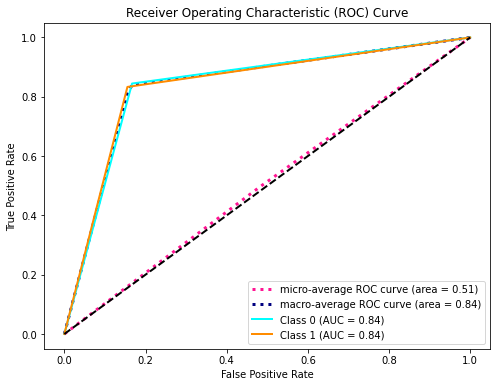

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from scipy import interp

def plot_AUC_ROC(y_true, y_pred, n_classes):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred == i)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve((y_true.ravel() == y_pred.ravel()), (y_pred.ravel() == 1))
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
        
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot ROC curves
    plt.figure(figsize=(8, 6))
    plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]), color='deeppink', linestyle='dotted', linewidth=3)
    plt.plot(fpr["macro"], tpr["macro"], label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]), color='navy', linestyle=':', linewidth=3)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, linewidth=2, label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    
    # Save the AUC ROC curve plot as an image file
    plt.savefig('C:/Users/MVI_lab_2/Desktop/sezier_detection_LSTM/final_model/images/cnn_logistic_regression_auc_roc_curve.png')
    
    plt.show()

# Example usage:
n_classes = 2  # Assuming binary classification
plot_AUC_ROC(y_test, logistic_regression_predictions, n_classes)

## Prediction through AdaBoost Classifier

In [40]:
from sklearn.ensemble import AdaBoostClassifier

# Create AdaBoost classifier
ada_boost_classifier = AdaBoostClassifier(n_estimators=100)

# Train the classifier
ada_boost_classifier.fit(X_train_flattened, y_train)

# Make predictions on the test set
ada_boost_predictions = ada_boost_classifier.predict(X_test_flattened)

# Calculate accuracy
ada_boost_accuracy = accuracy_score(y_test, ada_boost_predictions)
print("AdaBoost Accuracy:", ada_boost_accuracy)


AdaBoost Accuracy: 0.8235029051400833


In [41]:
from sklearn import metrics
report = metrics.classification_report(y_test, ada_boost_predictions)
print(report)
with open('C:/Users/MVI_lab_2/Desktop/sezier_detection_LSTM/final_model/images/cnn_ada_boost_classification_report.txt', 'w') as file:
    file.write(report)


              precision    recall  f1-score   support

           0       0.82      0.83      0.82    209715
           1       0.83      0.82      0.82    209714

    accuracy                           0.82    419429
   macro avg       0.82      0.82      0.82    419429
weighted avg       0.82      0.82      0.82    419429



Confusion Matrix: 
 [[174215  35500]
 [ 38528 171186]]
Normalized Confusion Matrix:
 [[0.83072265 0.16927735]
 [0.18371687 0.81628313]]


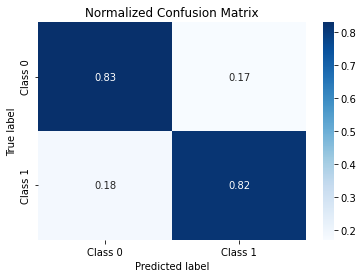

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, ada_boost_predictions)
print("Confusion Matrix: \n", cnf_matrix)

# Normalize confusion matrix
cm_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
print("Normalized Confusion Matrix:\n", cm_normalized)

classes = ['Class 0', 'Class 1']

# Plot normalized confusion matrix using Seaborn
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')

# Save the confusion matrix plot as an image file
plt.savefig('C:/Users/MVI_lab_2/Desktop/sezier_detection_LSTM/final_model/images/cnn_ada_boost_confusion_matrix.png')

plt.show()

In [43]:
print(ada_boost_predictions)

ada_matrix = np.zeros((ada_boost_predictions.size, 2))

for i in range(0,ada_boost_predictions.size):
  if(ada_boost_predictions[i] == 1):
    ada_matrix[i][1] = 1
  else:
    ada_matrix[i][0] = 1

print(ada_matrix)

[0 1 1 ... 1 0 0]
[[1. 0.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [1. 0.]
 [1. 0.]]


C:\Users\MVI_lab_2\AppData\Local\Temp\ipykernel_6372\4202582999.py:26: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


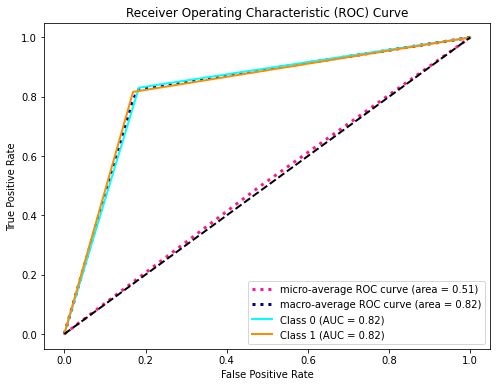

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from scipy import interp

def plot_AUC_ROC(y_true, y_pred, n_classes):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred == i)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve((y_true.ravel() == y_pred.ravel()), (y_pred.ravel() == 1))
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
        
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot ROC curves
    plt.figure(figsize=(8, 6))
    plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]), color='deeppink', linestyle='dotted', linewidth=3)
    plt.plot(fpr["macro"], tpr["macro"], label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]), color='navy', linestyle=':', linewidth=3)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, linewidth=2, label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    
    # Save the AUC ROC curve plot as an image file
    plt.savefig('C:/Users/MVI_lab_2/Desktop/sezier_detection_LSTM/final_model/images/cnn_ada_boost_auc_roc_curve.png')
    
    plt.show()

# Example usage:
n_classes = 2  # Assuming binary classification
plot_AUC_ROC(y_test, ada_boost_predictions, n_classes)

In [45]:
import tensorflow as tf

# Evaluate the model
evaluation = model.evaluate(x_test, y_test)

# Print evaluation metrics
print("Evaluation Loss:", evaluation[0])
print("Evaluation Accuracy:", evaluation[1])


13108/13108 [==============================] - 204s 16ms/step - loss: 0.1005 - accuracy: 0.9734
Evaluation Loss: 0.10046490281820297
Evaluation Accuracy: 0.973421037197113


## All classifier Accuracy

In [46]:
import tensorflow as tf
from tabulate import tabulate

# Define the data as a list of lists, where each inner list represents a row
data = [
    ["Model", "Accuracy"],
    ["Custom CNN Model", evaluation[1]],  # Replacing VGG16 Model with Custom CNN Model and using the actual test accuracy
    ["Decision Tree", decision_tree_accuracy],
    ["Random Forest", rf_accuracy],
    ["Support Vector Machine", svm_accuracy],
    ["Naive Bayes", nb_accuracy],
    ["Logistic Regression", logistic_regression_accuracy],
    ["AdaBoost", ada_boost_accuracy]
]

# Sort the data by accuracy, skipping the header and the first data row (Custom CNN Model)
sorted_data = sorted(data[1:], key=lambda x: x[1], reverse=True)
sorted_data.insert(0, data[0])  # Reinserting the header at the top

# Print the data in tabular form
print(tabulate(sorted_data, headers="firstrow", tablefmt="grid"))


ModuleNotFoundError: No module named 'tabulate'

In [ ]:
import tensorflow as tf
from tabulate import tabulate
import matplotlib.pyplot as plt

# Define the data as a list of lists, where each inner list represents a row
data = [
    ["Model", "Accuracy"],
    ["Custom CNN Model", evaluation[1]],  # Replacing VGG16 Model with Custom CNN Model and using the actual test accuracy
    ["Decision Tree", decision_tree_accuracy],
    ["Random Forest", rf_accuracy],
    ["Support Vector Machine", svm_accuracy],
    ["Naive Bayes", nb_accuracy],
    ["Logistic Regression", logistic_regression_accuracy],
    ["AdaBoost", ada_boost_accuracy]
]

# Sort the data by accuracy, skipping the header and the first data row (Custom CNN Model)
sorted_data = sorted(data[1:], key=lambda x: x[1], reverse=True)
sorted_data.insert(0, data[0])  # Reinserting the header at the top

# Print the data in tabular form
print(tabulate(sorted_data, headers="firstrow", tablefmt="grid"))

# Plot and save the table as an image
fig, ax = plt.subplots(figsize=(10, len(sorted_data)*0.4))  # Adjust figsize as needed
ax.axis('tight')
ax.axis('off')
ax.table(cellText=sorted_data, colLabels=sorted_data[0], loc='center')
plt.tight_layout()
plt.savefig('C:/Users/MVI_lab_2/Desktop/sezier_detection_LSTM/final_model/images/table_image.png')  # Save the image as table_image.png
plt.show()
